# Install and load dependencies

In [2]:
%pip install pydeseq2
%pip install scanpy
%pip install sanbomics
%pip install bioinfokit
%pip install gseapy
%pip install pykegg
%pip install requests_cache

Note: you may need to restart the kernel to use updated packages.
Note: you may need to restart the kernel to use updated packages.
Note: you may need to restart the kernel to use updated packages.
Note: you may need to restart the kernel to use updated packages.
Note: you may need to restart the kernel to use updated packages.
Note: you may need to restart the kernel to use updated packages.
Note: you may need to restart the kernel to use updated packages.


In [3]:
from pydeseq2.dds import DeseqDataSet
from pydeseq2.ds import DeseqStats
from functools import reduce
from sanbomics.plots import volcano
from bioinfokit import analys,visuz
from gseapy.plot import gseaplot
from PIL import Image
from Bio.KEGG import REST

import gseapy as gp
import pandas as pd
import seaborn as sns
import scanpy as sc
import numpy as np
import matplotlib.pyplot as plt
import pykegg
import requests_cache

/Users/shahjess/anaconda3/lib/python3.11/site-packages/pandas/core/arrays/masked.py:60: UserWarning: Pandas requires version '1.3.6' or newer of 'bottleneck' (version '1.3.5' currently installed).
  from pandas.core import (


# Run DeSeq2

In [4]:
merged = pd.read_csv('../data/raw/bad_GoodDiffs.tsv', delimiter='\t')
merged.set_index(merged.columns[0], inplace=True)
merged.sort_index(inplace=True)
merged = merged.astype(int)

In [5]:
labels = ['Poor Diff'] * 3 + ['Functional Diff'] * 3

metadata = pd.DataFrame(zip(merged.index, labels),
                        columns = ['Sample', 'Condition'])
metadata = metadata.set_index('Sample')

In [6]:
dds = DeseqDataSet(counts=merged,
            metadata=metadata,
            design_factors="Condition",
            ref_level = ["Condition", "Functional Diff"])

In [7]:
dds.deseq2()

Fitting size factors...
... done in 0.00 seconds.

/Users/shahjess/anaconda3/lib/python3.11/site-packages/pandas/core/arrays/masked.py:60: UserWarning: Pandas requires version '1.3.6' or newer of 'bottleneck' (version '1.3.5' currently installed).
  from pandas.core import (
/Users/shahjess/anaconda3/lib/python3.11/site-packages/pandas/core/arrays/masked.py:60: UserWarning: Pandas requires version '1.3.6' or newer of 'bottleneck' (version '1.3.5' currently installed).
  from pandas.core import (
/Users/shahjess/anaconda3/lib/python3.11/site-packages/pandas/core/arrays/masked.py:60: UserWarning: Pandas requires version '1.3.6' or newer of 'bottleneck' (version '1.3.5' currently installed).
  from pandas.core import (
/Users/shahjess/anaconda3/lib/python3.11/site-packages/pandas/core/arrays/masked.py:60: UserWarning: Pandas requires version '1.3.6' or newer of 'bottleneck' (version '1.3.5' currently installed).
  from pandas.core import (
/Users/shahjess/anaconda3/lib/python3.11/site-pac

In [8]:
stat_res = DeseqStats(dds, contrast = ('Condition','Functional Diff','Poor Diff'))

stat_res.summary()
res = stat_res.results_df

Running Wald tests...


Log2 fold change & Wald test p-value: Condition Functional Diff vs Poor Diff
          baseMean  log2FoldChange     lfcSE      stat    pvalue      padj
A1BG      0.000000             NaN       NaN       NaN       NaN       NaN
A1CF      0.000000             NaN       NaN       NaN       NaN       NaN
A2M       2.288279        4.616992  2.032283  2.271826  0.023097       NaN
A2ML1     0.000000             NaN       NaN       NaN       NaN       NaN
A3GALT2   0.000000             NaN       NaN       NaN       NaN       NaN
...            ...             ...       ...       ...       ...       ...
ZXDC      4.628338        1.030326  0.668509  1.541230  0.123261  0.286254
ZYG11A    0.000000             NaN       NaN       NaN       NaN       NaN
ZYG11B    7.923587        1.233172  0.528727  2.332340  0.019683  0.069842
ZYX      66.483619       -0.522566  0.206068 -2.535887  0.011216  0.045552
ZZEF1     3.482582        0.367095  0.734882  0.499529  0.617407  0.793078

[19936 rows x 6 column

... done in 0.38 seconds.



# Differentially Expressed Genes

In [9]:
#Filter based on p-value
ranking = res[res['pvalue'] <= 0.05]

#Sort based on abs log2 fold change
ranking = ranking[['log2FoldChange']].dropna()
ranking['abs_l2FC'] = ranking['log2FoldChange'].abs()
ranking.sort_values(by='abs_l2FC', ascending=False, inplace=True)
ranking = ranking[ranking['abs_l2FC'] > 1]

ranking.drop(columns=['abs_l2FC'], inplace=True)


ranking

,log2FoldChange
MYH7,11.651774
SHISA3,-11.372107
CKM,10.765128
HSPB3,10.467527
PLAT,-9.600793
...,...
ACADM,1.004345
GBA2,1.004093
FGFRL1,-1.002931
RRAGA,1.002807


In [10]:
pre_res = gp.prerank(rnk=ranking, # or rnk = rnk,
                     gene_sets='GO_Biological_Process_2021',
                     threads=4,
                     min_size=5,
                     max_size=1000,
                     permutation_num=1000, # reduce number to speed up testing
                     outdir=None, # don't write to disk
                     seed=6,
                     verbose=True, # see what's going on behind the scenes
                    )

2024-04-12 17:30:07,644 [WARNING] Duplicated values found in preranked stats: 7.57% of genes
The order of those genes will be arbitrary, which may produce unexpected results.
2024-04-12 17:30:07,645 [INFO] Parsing data files for GSEA.............................
2024-04-12 17:30:07,646 [INFO] Enrichr library gene sets already downloaded in: /Users/shahjess/.cache/gseapy, use local file
2024-04-12 17:30:07,699 [INFO] 4097 gene_sets have been filtered out when max_size=1000 and min_size=5
2024-04-12 17:30:07,701 [INFO] 1939 gene_sets used for further statistical testing.....
2024-04-12 17:30:07,701 [INFO] Start to run GSEA...Might take a while..................
2024-04-12 17:30:12,085 [INFO] Congratulations. GSEApy runs successfully................



In [11]:
out = []

for term in list(pre_res.results):
    out.append([term,
               pre_res.results[term]['fdr'],
               pre_res.results[term]['es'],
               pre_res.results[term]['nes'],
               pre_res.results[term]['gene %'],
               pre_res.results[term]['lead_genes'],])

out_df = pd.DataFrame(out, columns = ['Term','fdr', 'es', 'nes','gene %','lead_genes']).sort_values('nes').reset_index(drop = True)

out_df['abs_nes'] = abs(out_df['nes'])  # Create a new column with absolute NES values
out_df = out_df.sort_values('abs_nes', ascending=False).reset_index(drop=True)

out_df.drop('abs_nes', axis=1, inplace=True)

# Save the sorted DataFrame to a TSV file
out_df

,Term,fdr,es,nes,gene %,lead_genes
0,heart contraction (GO:0060047),0.000000,0.837049,3.146881,8.11%,MYH7;MYL2;CSRP3;TCAP;MYL3;MYBPC3;SCN5A;TNNC1;T...
1,muscle contraction (GO:0006936),0.000000,0.681698,3.117361,8.84%,MYH7;LMOD2;MYL2;CRYAB;TCAP;MYL3;MYOM1;MYBPC3;K...
2,striated muscle contraction (GO:0006941),0.000000,0.785731,3.032540,8.34%,MYH7;CSRP3;TCAP;MYL3;MYBPC3;KLHL41;SCN5A;TNNC1...
3,cardiac muscle contraction (GO:0060048),0.000000,0.790498,2.958379,8.11%,MYH7;CSRP3;TCAP;MYL3;MYBPC3;SCN5A;TNNC1;TNNI3;...
4,actin-myosin filament sliding (GO:0033275),0.000000,0.736921,2.805223,8.84%,MYH7;MYL2;TCAP;MYL3;MYBPC3;TNNC1;ACTN2;TNNI3;T...
...,...,...,...,...,...,...
1934,establishment of protein localization to extra...,0.998318,-0.175856,-0.423677,22.97%,ARL4D;OLFM2
1935,organic substance transport (GO:0071702),0.998556,0.116511,0.416366,9.57%,ABCA3;RILP
1936,protein K48-linked ubiquitination (GO:0070936),0.997428,0.144620,0.414125,85.59%,KLHL3;RNF115;UBE2B;UBE2E2;UBE2Q2;UBE2E1;UBE2C;...
1937,activation of GTPase activity (GO:0090630),1.000000,-0.126929,-0.368474,87.40%,ARHGAP22;TIAM1;SIPA1;GMIP;TBC1D16;RABGAP1;TBC1...


# Heat Map

In [12]:
import sys
sys.setrecursionlimit(10000)  # Set a higher recursion limit (adjust the value as needed)

/Users/shahjess/anaconda3/lib/python3.11/site-packages/seaborn/matrix.py:560: UserWarning: Clustering large matrix with scipy. Installing `fastcluster` may give better performance.
/Users/shahjess/anaconda3/lib/python3.11/site-packages/seaborn/matrix.py:560: UserWarning: Clustering large matrix with scipy. Installing `fastcluster` may give better performance.


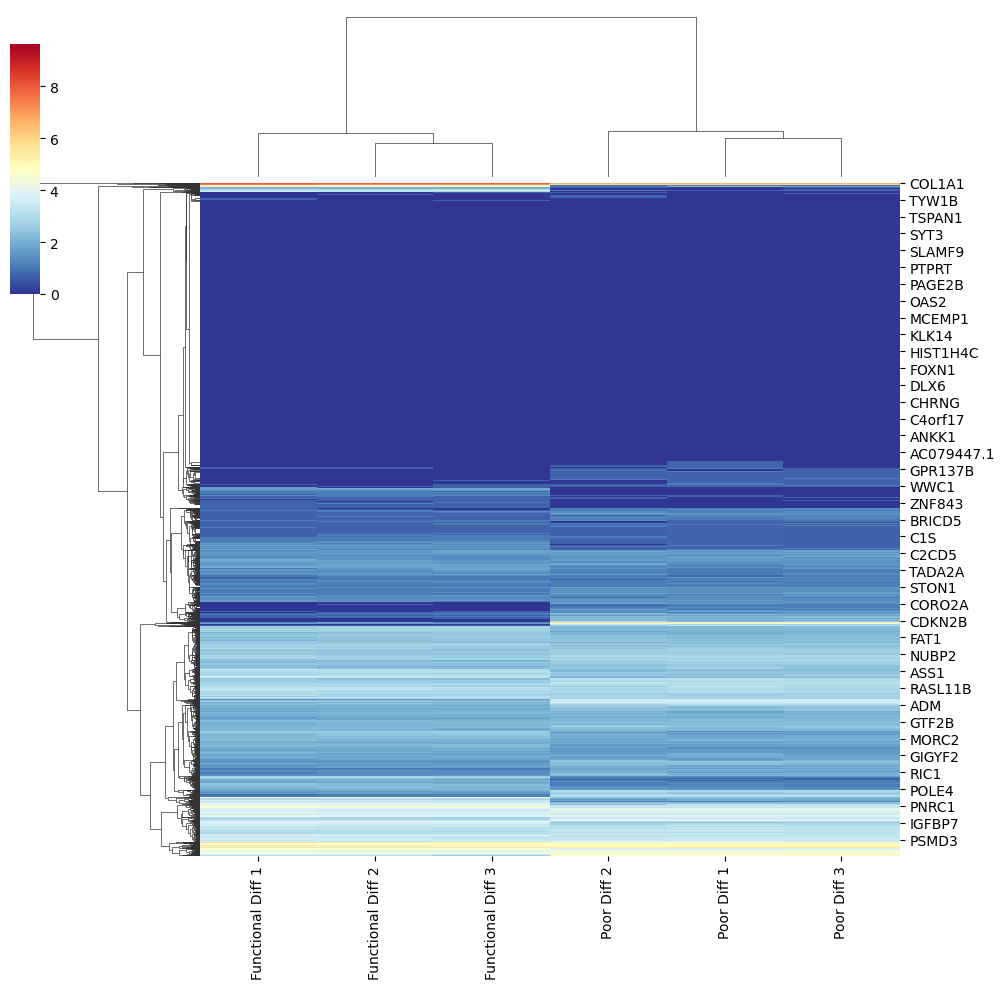

In [13]:
dds.layers['log1p'] = np.log1p(dds.layers['normed_counts'])
dds_res = dds[:, res.index]

pattern_repetitions = {'Poor Diff': 3, 'Functional Diff': 3}
col_labels = [f'{pattern} {i}' for pattern, repetitions in pattern_repetitions.items() for i in range(1, repetitions + 1)]

grapher_res = pd.DataFrame(dds_res.layers['log1p'].T,
                       index=dds_res.var_names, columns=col_labels)

sns.clustermap(grapher_res, cmap='RdYlBu_r',cbar_pos=(0, 0.7, .03, .25))

In [14]:
cardiac_genes = pd.read_csv('../data/raw/cardiac_genes.csv', delimiter='\t')

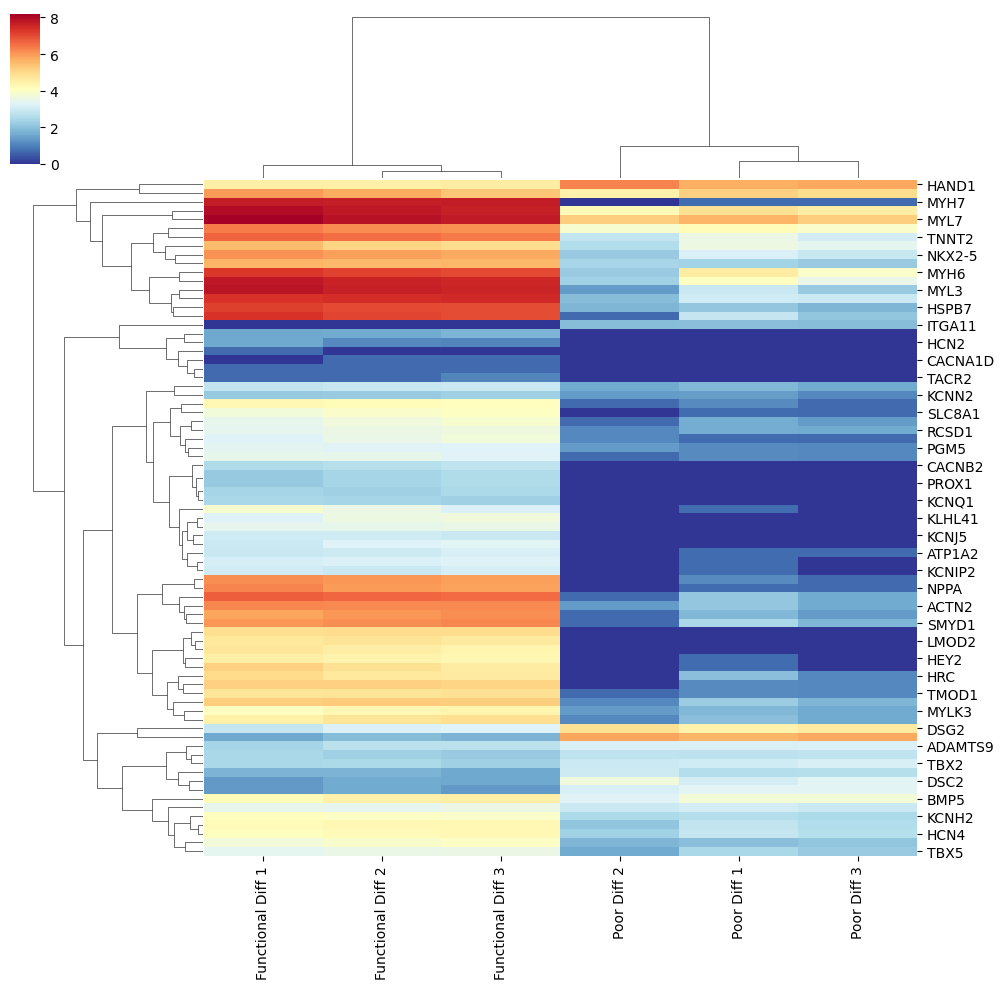

In [15]:
subset_grapher_res = grapher_res.loc[cardiac_genes['Gene']]
subset_grapher_res = subset_grapher_res.loc[~(grapher_res == 0).all(axis=1)]


sns.clustermap(subset_grapher_res, cmap='RdYlBu_r',cbar_pos=(0, 0.83, .03, .15))
plt.savefig('../figures/Fig 2a Good vs Bad Cardiac Heatmap.png')

# KEGG Pathway Analysis

In [16]:
## Cache all the downloaded
requests_cache.install_cache('pykegg_cache')

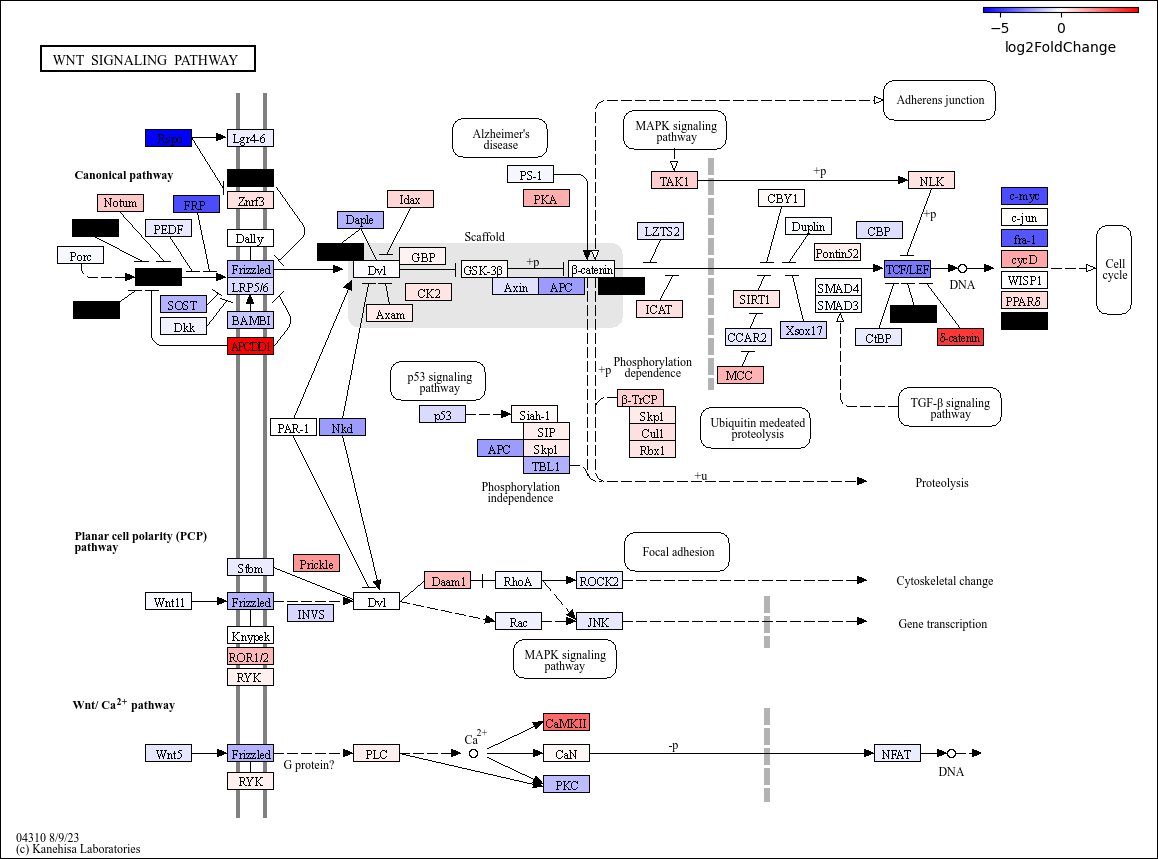

In [21]:
pykegg.deseq2_raw_map(res, pid="hsa04310", legend_width=2)

In [20]:
plot = pykegg.deseq2_raw_map(res, pid="hsa04310", legend_width=2)
plot.save('../figures/Fig S1 WNT.png')